In [1]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
from qiskit import IBMQ
from qiskit.providers.aer.noise import NoiseModel
# Loading your IBM Quantum account(s)
token = IBMQ.save_account('24f9b17bb2ed402e361d6135ce47685773353c2456e773993f11cffbc7d378f47c760784f62935349429e848999e1029cc97eead6c183bd45a5bb1ce9c784628')

configrc.store_credentials:WARNING:2022-07-09 12:07:58,176: Credentials already present. Set overwrite=True to overwrite.


In [7]:
def all_error(circ, qubits):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error
    from qiskit.providers.ibmq.job import job_monitor
    from qiskit.providers.ibmq import least_busy
    
    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    all_err = NoiseModel()
    all_err.add_all_qubit_quantum_error(re_err,"reset")
    all_err.add_all_qubit_quantum_error(meas_err,"measure")
    all_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    all_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    
    
       # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        all_err.add_quantum_error(errors_reset[j], "reset", [j])
        all_err.add_quantum_error(errors_measure[j], "measure", [j])
        all_err.add_quantum_error(errors_u1[j], "u1", [j])
        all_err.add_quantum_error(errors_u2[j], "u2", [j])
        all_err.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            all_err.add_quantum_error(errors_cx[j][k], "cx", [j, k])
        
    
    
    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    all_err.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    provider = IBMQ.load_account()
    get_provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
    backends = provider.backends(simulator=False, operational=True)
    print(backends)
    C = ['ibmq_manila']
    for i in range(len(C)):
        
        
        backend = provider.get_backend(C[i])
        if(backend.configuration().n_qubits > 2):
            print(backend, end='\n')
            noise_model = NoiseModel.from_backend(backend)
            print(noise_model, end='\n')
            coupling_map = backend.configuration().coupling_map
            basis_gates = noise_model.basis_gates
            print(basis_gates, end='\n')
            noise_model = NoiseModel.from_backend(backend).to_dict()
            #noise_model = NoiseModel.from_backend(backend).to_dict()
            #real_hardware_run = transpile(circ, noise_model)
            #qobj = assemble(circ, backend=backend, shots=1024)
        # execute the circuit
            #job = backend.run(qobj)
            real_run = execute(circ, backend= backend, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result()
            #job = backend.run(real_run, shots= 1024)
            #print(real_run.job_id(), end='\n')
            #job_monitor(real_run)
            counts = real_run.get_counts()
            plot_bit= plot_histogram(counts)
            display(plot_bit)
            sim_noise = AerSimulator(noise_model=all_err)
    
            tnoise = transpile(circ, sim_noise)
            result_all_err = sim_noise.run(tnoise).result()
            counts_all_err = result_all_err.get_counts()
    
    
            legend = ['real_device', 'simulated_noise']
            plot_bit = plot_histogram([counts, counts_all_err], legend= legend)
            display(plot_bit)
    
    
            num_binary_states = 2**qubits

            # get the total counts for two dictionaries
            N1 = sum(counts.values())
            N2 = sum(counts_all_err.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
            for number in range(2**qubits):
            
            
            
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
                binary_state = '{0:b}'.format(number).zfill(qubits)

                if binary_state not in counts:
                    
        
                    counts[binary_state] = 0
        
                if binary_state not in counts_all_err:
                
                    counts_all_err[binary_state] = 0

    # following loop actually computes the TVD between two distributions
            tvd = 0
            print(' TVD Distribution')
            for key in counts:
                print(key)
                print(counts[key], counts_all_err[key])
                tvd = tvd + 0.5 * abs(counts[key]/N1 - counts_all_err[key]/N2)
                print(tvd)
    
    
            print('Jensen-Shannon Distance')
            from scipy.spatial import distance
            a = counts.values()
            b = counts_all_err.values()
            data_a = list(a)
            data_b = list(b)
            arr_a = np.array(data_a)
            arr_b = np.array(data_b)
            jsd = distance.jensenshannon(arr_a, arr_b)
            print(jsd)
    
            print('Hellinger Distance') 
            _SQRT2 = np.sqrt(2)
            hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
            print(hell1)
            hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
            print(hell2)
            hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
            print(hell3)
            backends.remove(backend)
    
    
    
    return plot_bit, tvd, jsd, hell1, hell2, hell3

In [3]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()


┌───┐          ┌─┐      
q0_0: ┤ H ├──■───────┤M├──────
      └───┘┌─┴─┐     └╥┘┌─┐   
q0_1: ─────┤ X ├──■───╫─┤M├───
           └───┘┌─┴─┐ ║ └╥┘┌─┐
q0_2: ──────────┤ X ├─╫──╫─┤M├
                └───┘ ║  ║ └╥┘
c0: 3/════════════════╩══╩══╩═
                      0  1  2

[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibm_oslo
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx',

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


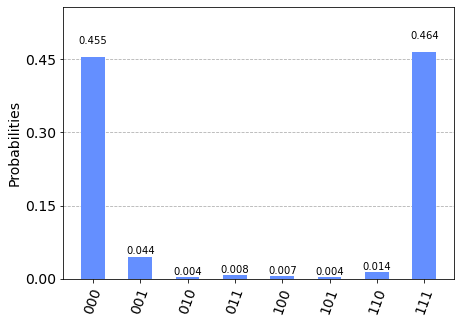

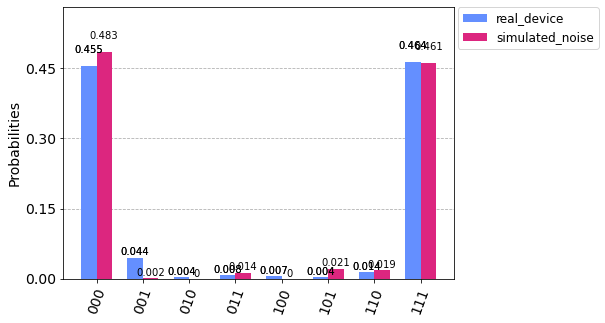

 TVD Distribution
000
1818 495
0.014449218749999992
001
177 2
0.03559765624999999
010
18 0
0.03784765624999999
011
31 14
0.04080859375
100
27 0
0.04418359375
101
18 22
0.05267578125
110
57 19
0.054828125
111
1854 472
0.05610937500000001
Jensen-Shannon Distance
0.526726145096837
Hellinger Distance
34.92805394793447
34.92805394793447
34.92805394793447
ibmq_belem
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (1, 0)), ('cx', (0, 1)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), 

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


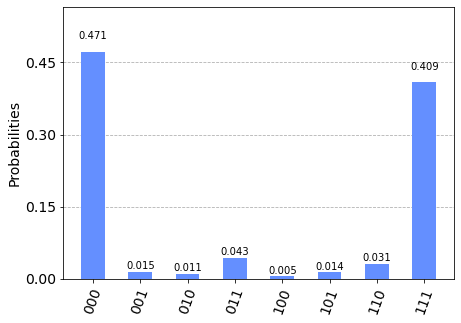

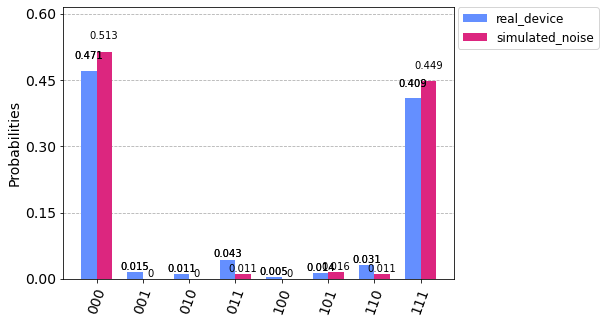

 TVD Distribution
000
1883 525
0.02097265625
001
62 1
0.028234375
010
45 0
0.033859375
011
174 11
0.050238281249999996
100
21 0
0.05286328125
101
55 16
0.05380078125
110
124 11
0.0639296875
111
1636 460
0.08403906250000001
Jensen-Shannon Distance
0.5378604946929311
Hellinger Distance
35.43519819990118
35.43519819990118
35.43519819990118
ibmq_quito
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


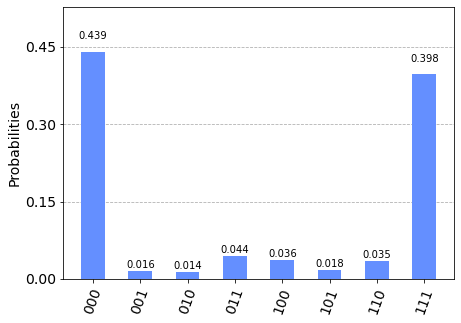

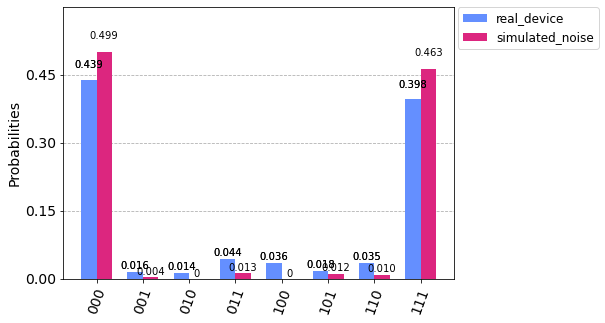

 TVD Distribution
000
1756 511
0.03001171875
001
65 4
0.03618359375
010
56 0
0.04318359375
011
177 13
0.0589609375
100
144 0
0.07696093749999999
101
72 12
0.08010156249999999
110
140 10
0.09271874999999999
111
1590 474
0.12541406249999998
Jensen-Shannon Distance
0.5403902459896887
Hellinger Distance
35.48543649351499
35.48543649351499
35.48543649351499
ibmq_lima


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]
['cx', 'id', 'reset', 'rz', 'sx', 'x']


C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.238017175754). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\providers\aer\noise\device\models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (139900.07441816825 > 2 * 59926.

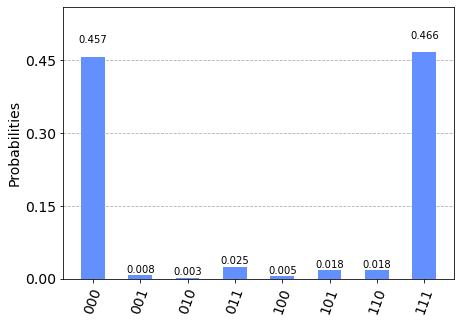

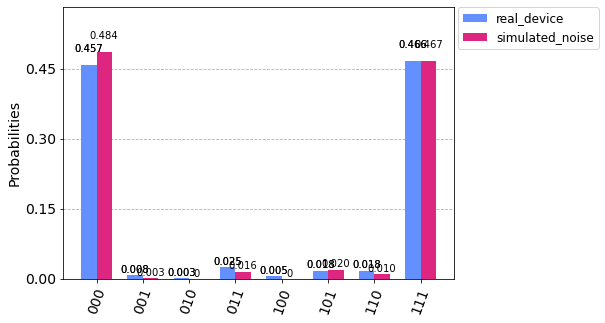

 TVD Distribution
000
1829 496
0.013562500000000005
001
33 3
0.016222656250000005
010
12 0
0.017722656250000007
011
100 16
0.022410156250000007
100
22 1
0.024671875000000006
101
72 20
0.02543750000000001
110
70 10
0.02930468750000001
111
1862 478
0.029953124999999997
Jensen-Shannon Distance
0.5682178006027807
Hellinger Distance
36.81921862693822
36.81921862693822
36.81921862693822
ibm_nairobi
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (3, 5)), ('cx', (1, 3)),

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


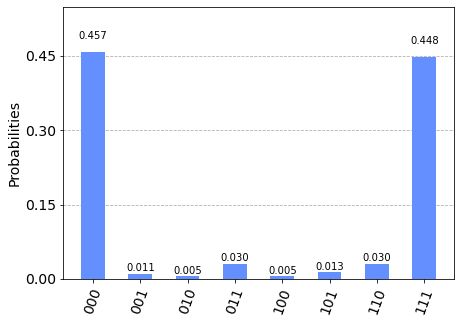

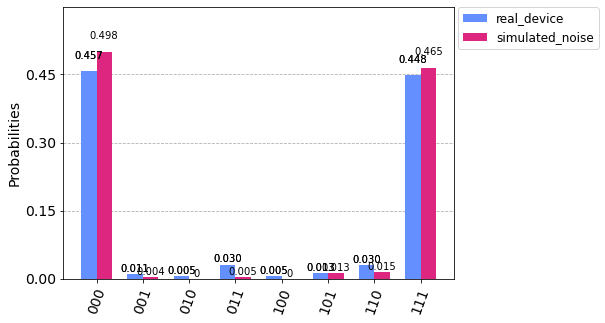

 TVD Distribution
000
1828 510
0.02052343749999999
001
43 4
0.02394531249999999
010
22 1
0.026207031249999988
011
122 5
0.039015624999999984
100
22 0
0.04176562499999999
101
53 13
0.042042968749999986
110
120 15
0.049718749999999985
111
1790 476
0.05839062499999998
Jensen-Shannon Distance
0.5679874393710369
Hellinger Distance
36.69746911974399
36.69746911974399
36.69746911974399
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('res

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


IBMQJobApiError: '\'HTTPSConnectionPool(host=\\\'api-qcon.quantum-computing.ibm.com\\\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/62c92216beddc25d3d2c2149/v/1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host=\\\'api-qcon.quantum-computing.ibm.com\\\', port=443): Read timed out. (read timeout=5.0)"))\''

In [4]:
all_error(ghz_circ, len(q_ghz))

ibmqfactory.load_account:WARNING:2022-07-09 13:01:01,849: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]
ibmq_manila
NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'id', 'reset', 'measure', 'cx', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (4, 3)), ('cx', (3, 4)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (1, 2)), ('cx', (2, 

C:\Users\Sakib\miniconda3\envs\qiskit\lib\site-packages\qiskit\execute_function.py:401: UserWarning: noise_model is not a recognized runtime option and may be ignored by the backend.
  job = backend.run(experiments, **run_kwargs)


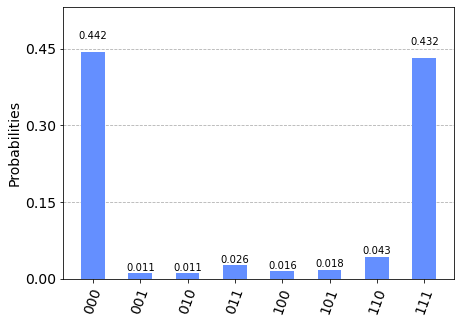

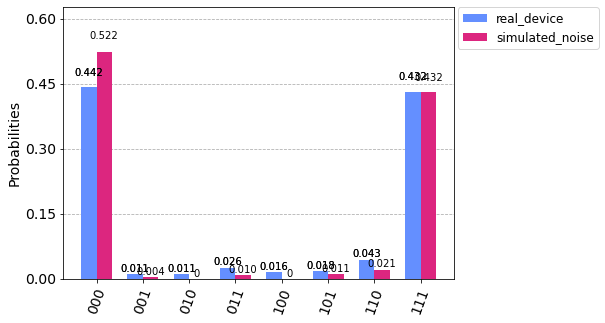

 TVD Distribution
000
1769 535
0.04010546875000001
001
43 4
0.04352734375000001
010
46 0
0.04927734375000001
011
106 10
0.057644531250000006
100
63 0
0.06551953125000001
101
71 11
0.0690234375
110
174 22
0.08003125
111
1728 442
0.0802109375
Jensen-Shannon Distance
0.5702797408342604
Hellinger Distance
36.894097346130906
36.894097346130906
36.894097346130906


(<Figure size 504x360 with 1 Axes>,
 0.0802109375,
 0.5702797408342604,
 36.894097346130906,
 36.894097346130906,
 36.894097346130906)

In [8]:
all_error(ghz_circ, len(q_ghz))